In [ ]:
# Instalar pacotes necessários
%pip install yfinance pandas numpy matplotlib scikit-learn

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Verificar disponibilidade da GPU
print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Número de GPUs:", torch.cuda.device_count())
    print("Nome da GPU:", torch.cuda.get_device_name(0))

CUDA disponível: False


In [3]:
# Baixar dados
ticker = "VALE"
data = yf.download(ticker, start="2010-01-01", end="2023-10-01")

# Verificar e ajustar as colunas se forem MultiIndex
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)


[*********************100%***********************]  1 of 1 completed


In [4]:
data = data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']]
data.rename(columns={'Adj Close': 'adj_close', 'Close': 'close', 'High': 'high',
                     'Low': 'low', 'Open': 'open', 'Volume': 'volume'}, inplace=True)

# Visualizar os dados
print(data.head())

Price       adj_close      close       high        low       open    volume
Date                                                                       
2010-01-04  13.323677  30.250000  30.280001  29.530001  29.590000  19384000
2010-01-05  13.464622  30.570000  31.020000  30.090000  30.139999  24200200
2010-01-06  13.680449  31.059999  31.430000  30.459999  30.570000  24190900
2010-01-07  13.720089  31.150000  31.170000  30.570000  31.020000  16064900
2010-01-08  13.865438  31.480000  31.879999  31.270000  31.379999  14727200


In [5]:
adj_close_index = data.columns.get_loc('close')
print("Índice de 'close':", adj_close_index)

Índice de 'close': 1


In [6]:

# Definir lookback e futuros passos
lookback = int(365)  # 1 ano
future_steps = [1, 2, 5, 15]

# Dividir os dados em treino e teste
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Normalização dos dados
scaler = MinMaxScaler()
scaler.fit(train_data)  # Ajustar o scaler apenas no conjunto de treino

# Transformar todo o conjunto de dados
data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

In [7]:
# Função para criar sequências
def create_sequences(data, lookback, future_steps, target_column='close'):
    sequences = []
    targets = []
    data_values = data.values
    target_idx = data.columns.get_loc(target_column)
    max_future_step = max(future_steps)
    for i in range(len(data_values) - lookback - max_future_step + 1):
        seq = data_values[i:i + lookback]
        target_indices = [i + lookback + step - 1 for step in future_steps]
        target = data_values[target_indices, target_idx]
        sequences.append(seq)
        targets.append(target)
    sequences = np.array(sequences)
    targets = np.array(targets)
    # Garantir que targets tenha a forma (n_samples, n_steps)
    targets = targets.reshape(-1, len(future_steps))
    return sequences, targets

In [8]:
# Criar sequências e targets
sequences, targets = create_sequences(data_scaled, lookback, future_steps)

# Calcular o índice de divisão para as sequências
sequence_split_index = split_index - lookback - max(future_steps) + 1

# Dividir em treino e teste
X_train = sequences[:sequence_split_index]
y_train = targets[:sequence_split_index]

X_test = sequences[sequence_split_index:]
y_test = targets[sequence_split_index:]

# Dividir o conjunto de treino em treino e validação
val_size = int(len(X_train) * 0.1)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]

X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

print("Forma de X_train:", X_train.shape)  # (n_samples, lookback, n_features)
print("Forma de y_train:", y_train.shape)  # (n_samples, n_steps)
print("Forma de X_val:", X_val.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (2150, 365, 6)
Forma de y_train: (2150, 4)
Forma de X_val: (238, 365, 6)
Forma de y_val: (238, 4)
Forma de X_test: (692, 365, 6)
Forma de y_test: (692, 4)


In [9]:
# Definição do modelo LSTM (mantendo o modelo inicial)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Pegar apenas a última saída
        last_output = lstm_out[:, -1, :]  # Último passo de tempo
        # Aplicar dropout na última saída
        last_output = self.dropout(last_output)
        # Passar pela camada final
        output = self.fc(last_output)
        return output

In [10]:
# Configurações do modelo
input_size = X_train.shape[2]  # Número de features
hidden_size = 50
output_size = len(future_steps)
num_layers = 2

# Instanciar o modelo
model = LSTMModel(input_size, hidden_size, output_size, num_layers=num_layers)

In [11]:
# Configurar dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo usado: {device}")

# Mover o modelo para o dispositivo
model = model.to(device)

# Conversão para tensores e transferência para o dispositivo
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)

X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Verificar formas dos tensores
print("Forma de X_train_tensor:", X_train_tensor.shape)
print("Forma de y_train_tensor:", y_train_tensor.shape)

# %%
# Treinamento
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 60
train_losses = []
val_losses = []

Dispositivo usado: cpu
Forma de X_train_tensor: torch.Size([2150, 365, 6])
Forma de y_train_tensor: torch.Size([2150, 4])


In [12]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    # Verificar formas
    if epoch == 0:
        print("Forma de outputs:", outputs.shape)
        print("Forma de y_train_tensor:", y_train_tensor.shape)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validação
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{epochs}], Loss Treino: {loss.item():.4f}, Loss Validação: {val_loss.item():.4f}')

Forma de outputs: torch.Size([2150, 4])
Forma de y_train_tensor: torch.Size([2150, 4])
Época [10/60], Loss Treino: 0.0632, Loss Validação: 0.0157
Época [20/60], Loss Treino: 0.0288, Loss Validação: 0.0170
Época [30/60], Loss Treino: 0.0192, Loss Validação: 0.0051
Época [40/60], Loss Treino: 0.0102, Loss Validação: 0.0049
Época [50/60], Loss Treino: 0.0060, Loss Validação: 0.0017
Época [60/60], Loss Treino: 0.0047, Loss Validação: 0.0016


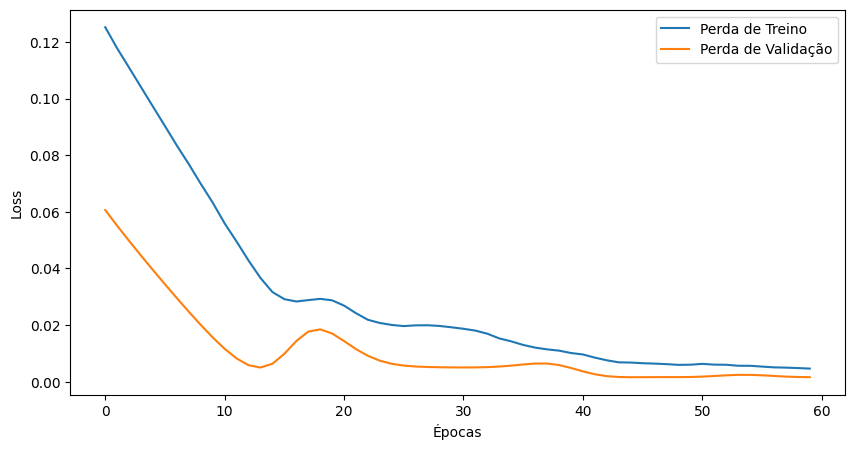

In [15]:
# Plotar as perdas
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Perda de Treino')
plt.plot(val_losses, label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Avaliação no conjunto de teste
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f"Loss no conjunto de teste: {test_loss.item():.4f}")

Loss no conjunto de teste: 0.0049


In [17]:
# Reverter a normalização para os valores reais
predictions_np = predictions.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Como apenas a coluna 'adj_close' foi prevista, precisamos inverter a normalização apenas para essa coluna
adj_close_index = data.columns.get_loc('close')

In [18]:
def inverse_transform(predictions, scaler, feature_index):
    n_samples, n_steps = predictions.shape
    n_features = scaler.scale_.shape[0]
    inv_predictions = np.zeros((n_samples, n_steps))
    for i in range(n_steps):
        # Criar um array vazio com o mesmo número de colunas
        full_data = np.zeros((n_samples, n_features))
        # Inserir as previsões na posição correta
        full_data[:, feature_index] = predictions[:, i]
        # Reverter a transformação
        inv_data = scaler.inverse_transform(full_data)
        # Armazenar a previsão invertida
        inv_predictions[:, i] = inv_data[:, feature_index]
    return inv_predictions

predictions_real = inverse_transform(predictions_np, scaler, adj_close_index)
y_test_real = inverse_transform(y_test_np, scaler, adj_close_index)


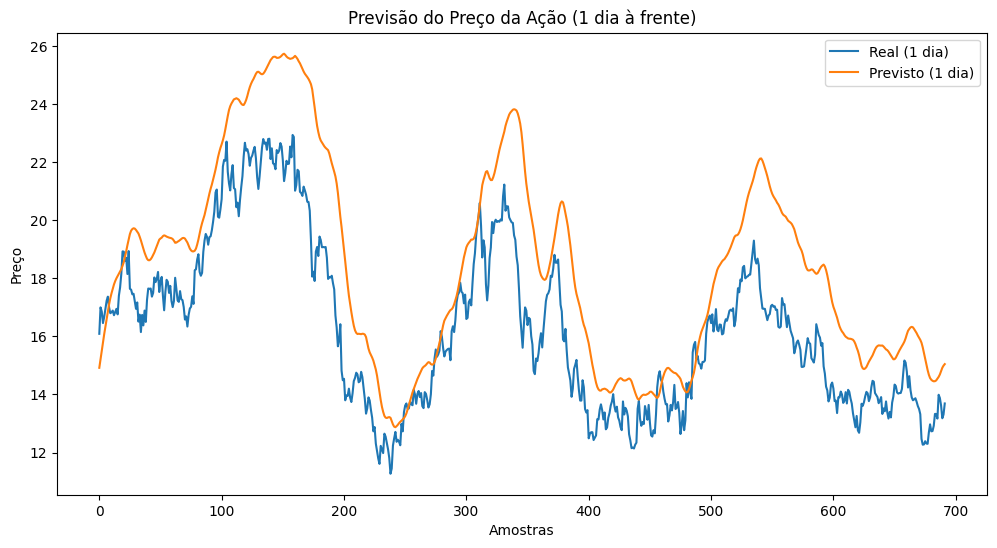

In [19]:
# Comparar valores reais e previstos para o horizonte de 1 dia
plt.figure(figsize=(12, 6))
plt.plot(y_test_real[:, 0], label="Real (1 dia)")
plt.plot(predictions_real[:, 0], label="Previsto (1 dia)")
plt.title("Previsão do Preço da Ação (1 dia à frente)")
plt.xlabel("Amostras")
plt.ylabel("Preço")
plt.legend()
plt.show()

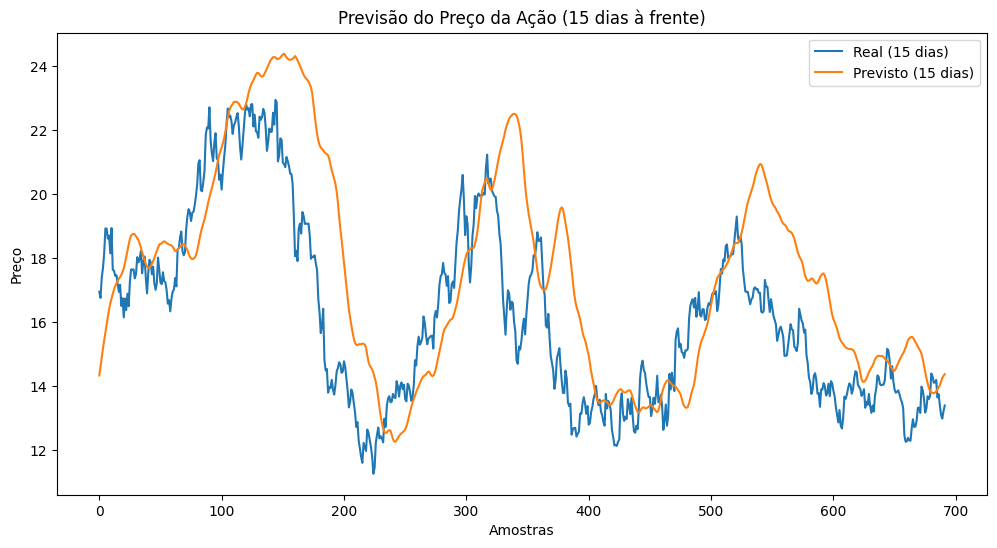

In [20]:
# Comparar valores reais e previstos para o horizonte de 15 dias
plt.figure(figsize=(12, 6))
plt.plot(y_test_real[:, -1], label="Real (15 dias)")
plt.plot(predictions_real[:, -1], label="Previsto (15 dias)")
plt.title("Previsão do Preço da Ação (15 dias à frente)")
plt.xlabel("Amostras")
plt.ylabel("Preço")
plt.legend()
plt.show()

In [21]:
# Calcular métricas
def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula o erro percentual absoluto médio (MAPE)."""
    # Evitar divisão por zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE
mae = mean_absolute_error(y_test_real, predictions_real)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_real, predictions_real))

# MAPE
mape = mean_absolute_percentage_error(y_test_real, predictions_real)

# Exibir resultados
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 1.94
Root Mean Square Error (RMSE): 2.45
Mean Absolute Percentage Error (MAPE): 12.01%
